# Companion Notebook to `playing-with-coronavirus-data` 
- [GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

> **NOTE: DATA ACQUISITION IS BEING RE-WORKED IN "Exploring Options for Replacing Covid Tracking Project Data_08-2021.ipnynb"** -08/12/21

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

- See `data_acquisition.py`> `FULL_WORKFLOW()` and `1_Replacing Covid Tracking Project - Simplified Workflow.ipynb` for details (for now)


# OBTAIN

In [1]:
RUN_FULL_WORKFLOW=True

In [2]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *
import os,glob,sys,joblib
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)

import statsmodels.tsa.api as tsa

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [3]:
%load_ext autoreload
%autoreload 2
import project_functions as fn
# import data_acquisition as da
# import coronavirus_functions as fn

## Data

> Data is stored as both separate csvs for each state as well as one big dictionary in a joblib file.

In [4]:
## Uncomment Cell to acquire new data
if RUN_FULL_WORKFLOW:
    df_states,STATES = fn.data.FULL_WORKFLOW()
else:
    print(f"[i] Using previously downloaded data...")
    df_states = pd.read_csv('data/combined_us_states_full_data.csv')
    STATES = joblib.load('data/STATE_DICT.joblib')

display(df_states.head())
STATES.keys()

========= RUNNING FULL WORKFLOW =========
[i] Retrieving kaggle dataset: antgoldbloom/covid19-data-from-john-hopkins-university
- Loading data from RAW_us_confirmed_cases.csv
- Loading data from RAW_us_deaths.csv
[i] Retrieving hospital data from https://healthdata.gov/resource/g62h-syeh.csv
[i] Workflow completed.
	Run time=0:00:40.586253 sec.
[i]The final files of note:
	data/combined_us_states_full_data.csv
	data/STATE_DICT.joblib


Cases  ...  adult_icu_bed_utilization_numerator
State_Code Date               ...                                     
AK         2020-03-23     39  ...                                  NaN
           2020-03-24     43  ...                                  NaN
           2020-03-25     50  ...                                  NaN
           2020-03-26     64  ...                                  NaN
           2020-03-27     75  ...                                  NaN

[5 rows x 42 columns]

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

# EDA

## Matching Hospital columns

#### Columns to find from the covid tracking project dataset: 

- "hospitalizedCurrently"/"hospitalizedCumulative"
- "inIcuCurrently","inIcuCumulative"
- "onVentilatorCurrently","onVentilatorCumulative"

In [5]:
compare_state='MD'

In [9]:
## OLD DATA
covid = fn.covid.CovidTrackingProject(verbose=True)
# covid

old_df = covid.df_states.copy()
old_df.index.name='Date'
old_md = old_df.groupby('state').get_group(compare_state).copy()
# old_md = old_md.set_index('date').sort_index()
old_md

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
ERROR
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"


,state,fips,positive,negative,death,recovered,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,pending,dataQualityGrade,lastUpdateEt,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,positiveIncrease,totalTestResults,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-07,MD,24,387319.0,3034546.0,7955.0,9703.0,818.0,35651.0,215.0,NaN,NaN,NaN,NaN,NaN,3/7/2021 10:00,8097590.0,472716.0,NaN,387319.0,709,8097590.0,33128,14,79
2021-03-06,MD,24,386610.0,3032496.0,7941.0,9703.0,830.0,35572.0,230.0,NaN,NaN,NaN,NaN,NaN,3/6/2021 10:00,8064462.0,471762.0,NaN,386610.0,932,8064462.0,40384,11,194
2021-03-05,MD,24,385678.0,3024949.0,7930.0,9701.0,849.0,35378.0,229.0,NaN,NaN,NaN,NaN,NaN,3/5/2021 10:00,8024078.0,470625.0,NaN,385678.0,913,8024078.0,41728,8,74
2021-03-04,MD,24,384765.0,3018120.0,7922.0,9691.0,856.0,35304.0,216.0,NaN,NaN,NaN,NaN,NaN,3/4/2021 10:00,7982350.0,469489.0,NaN,384765.0,809,7982350.0,33723,3,81
2021-03-03,MD,24,383956.0,3012179.0,7919.0,9685.0,863.0,35223.0,228.0,NaN,NaN,NaN,NaN,NaN,3/3/2021 10:00,7948627.0,468532.0,NaN,383956.0,786,7948627.0,31296,14,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-09,MD,24,5.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2,NaN,0,0,0
2020-03-08,MD,24,3.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,NaN,0,0,0
2020-03-07,MD,24,3.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,NaN,0,0,0


In [10]:
def get_state(STATES, state='NY',drop_cols=True,drop_exprs=['coverage','denominator',
                                                           'numerator']):
    df_state= STATES[state].copy()
    
    
    if drop_cols:
        cols_to_drop = []
        for expr in drop_exprs:
            cols_to_drop.extend([c for c in df_state.columns if expr.lower() in c.lower()])
        df_state = df_state.drop(columns=cols_to_drop)
        
    return df_state

In [11]:
md = get_state(STATES,'MD',drop_exprs=[])
new_md = md.loc[old_df.index[-1]:old_df.index[0]].copy()
new_md

,Cases,Deaths,inpatient_bed_covid_utilization_coverage,staffed_adult_icu_bed_occupancy_coverage,inpatient_bed_covid_utilization_numerator,percent_of_inpatients_with_covid,percent_of_inpatients_with_covid_coverage,deaths_covid_coverage,inpatient_beds,adult_icu_bed_utilization,deaths_covid,percent_of_inpatients_with_covid_numerator,total_adult_patients_hospitalized_confirmed_covid_coverage,inpatient_bed_covid_utilization,inpatient_beds_utilization,adult_icu_bed_utilization_coverage,total_pediatric_patients_hospitalized_confirmed_covid_coverage,adult_icu_bed_covid_utilization_denominator,total_staffed_adult_icu_beds,total_pediatric_patients_hospitalized_confirmed_covid,inpatient_beds_used_covid,inpatient_bed_covid_utilization_denominator,total_staffed_adult_icu_beds_coverage,inpatient_beds_utilization_coverage,adult_icu_bed_covid_utilization_coverage,staffed_adult_icu_bed_occupancy,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,percent_of_inpatients_with_covid_denominator,adult_icu_bed_utilization_denominator,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,inpatient_beds_coverage,total_adult_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization_numerator,inpatient_beds_used_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,adult_icu_bed_utilization_numerator
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0,0,1.0,0,0.0,0.000000,1.0,1,6.0,NaN,0.0,0.0,0,0.000000,0.666667,NaN,0,NaN,NaN,NaN,0.0,6.0,0,1.0,NaN,NaN,0,4.0,NaN,4.0,1,4.0,6.0,1,NaN,NaN,NaN,1,NaN,NaN,0,NaN
2020-03-03,0,0,1.0,0,0.0,0.000000,1.0,1,6.0,NaN,6.0,0.0,0,0.000000,0.666667,NaN,0,NaN,NaN,NaN,0.0,6.0,0,1.0,NaN,NaN,0,4.0,NaN,4.0,1,4.0,6.0,1,NaN,NaN,NaN,1,NaN,NaN,0,NaN
2020-03-04,0,0,1.0,0,0.0,0.000000,1.0,1,6.0,NaN,0.0,0.0,0,0.000000,0.666667,NaN,0,NaN,NaN,NaN,0.0,6.0,0,1.0,NaN,NaN,0,4.0,NaN,4.0,1,4.0,6.0,1,NaN,NaN,NaN,1,NaN,NaN,0,NaN
2020-03-05,0,0,1.0,0,0.0,0.000000,1.0,1,6.0,NaN,0.0,0.0,0,0.000000,0.666667,NaN,0,NaN,NaN,NaN,0.0,6.0,0,1.0,NaN,NaN,0,4.0,NaN,4.0,1,4.0,6.0,1,NaN,NaN,NaN,1,NaN,NaN,0,NaN
2020-03-06,3,0,1.0,0,0.0,0.000000,1.0,1,6.0,NaN,0.0,0.0,0,0.000000,0.666667,NaN,0,NaN,NaN,NaN,0.0,6.0,0,1.0,NaN,NaN,0,4.0,NaN,4.0,1,4.0,6.0,1,NaN,NaN,NaN,1,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-04,384765,7922,60.0,61,1101.0,0.114699,60.0,60,12191.0,0.745627,12.0,1101.0,61,0.091142,0.792798,61.0,60,1333.0,1372.0,10.0,1101.0,12080.0,61,61.0,60.0,1023.0,60,9599.0,1372.0,9665.0,61,9665.0,12191.0,61,808.0,15.0,239.0,60,1086.0,0.179295,60,1023.0
2021-03-05,385678,7930,60.0,61,1063.0,0.111907,60.0,60,12097.0,0.739538,11.0,1063.0,61,0.088687,0.790692,61.0,60,1347.0,1386.0,9.0,1063.0,11986.0,61,61.0,60.0,1025.0,60,9499.0,1386.0,9565.0,61,9565.0,12097.0,61,801.0,11.0,247.0,60,1052.0,0.183370,60,1025.0
2021-03-06,386610,7941,60.0,61,1064.0,0.115677,60.0,60,12078.0,0.729769,9.0,1064.0,61,0.088911,0.766435,61.0,60,1345.0,1384.0,8.0,1064.0,11967.0,61,61.0,60.0,1010.0,60,9198.0,1384.0,9257.0,61,9257.0,12078.0,61,767.0,10.0,261.0,60,1054.0,0.194052,60,1010.0


### Compare Plots

In [12]:
# ax = old_md['positive'].plot(label='Old')
# new_md['Cases'].plot(ax=ax,label='New')
# ax.legend()

In [13]:
# new_md[[c for c in new_md.columns if 'icu' in c.lower()]]

In [14]:
from sklearn import metrics
# sns.set(context='notebook')
# plt.style.use('fivethirtyeight')
def compare_old_vs_new_cols(old_df,new_df,old_col = 'hospitalizedCurrently',
                            top_n=3):
    ## Compare cols vs inIcuCumulative 
    results = [['Old Col','New Col','RMSE']]
    FIGURES = {}

    for col in new_df.columns:
#         print('---'*20)
#         print(f"{col}")
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(f"{col} vs {old_col}")
        
        ## Save columns as vars and calc rmse
        data_concat = pd.merge(old_df[old_col].reset_index(),
                               new_md[col].reset_index(), on='Date',
                               how='outer')
        data_concat = data_concat.set_index("Date").fillna(0)
        old_data = data_concat[old_col].copy()
        new_data = data_concat[col].copy()
        
        ## calc andd save metrics
        rmse = metrics.mean_squared_error(old_data,new_data,squared=False)
        results.append([old_col,col,rmse])
        
#         res = pd.DataFrame(results[1:],columns=results[0])
        old_data.plot(label='Old',ax=ax,lw=3)
        new_data.plot(ax=ax,label='New',ls=':')
        fig.suptitle(f"{old_col} vs {col} (RMSE={round(rmse,2)})",y=1.02)
        ax.legend()
        
        fig.tight_layout()
        FIGURES[col] = fig
        plt.close(1)
#         del fig
#         plt.show()
#         print('\n\n')
        
        
    try: 
        res = pd.DataFrame(results[1:],columns=results[0]).sort_values('RMSE')
    except Exception as e:
        print("[!] Error",e)
        print('Returning list instead of dataframe.')
        return  results

    order = list(res["New Col"].head(top_n))
    for top_col in order:
        print('---'*20)
        print(f"{top_col}")
        display(FIGURES[top_col])
        print('\n\n')

    return res


------------------------------------------------------------
Deaths


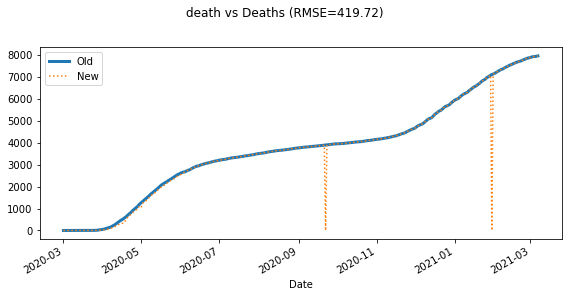




------------------------------------------------------------
inpatient_beds_used_covid


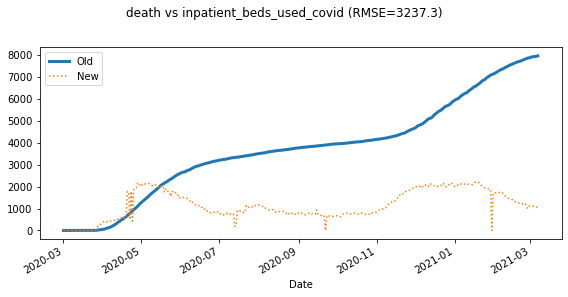




------------------------------------------------------------
percent_of_inpatients_with_covid_numerator


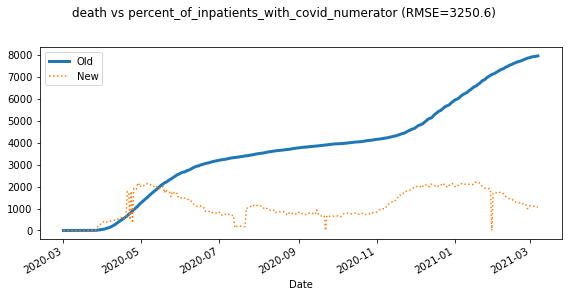

In [15]:
res = compare_old_vs_new_cols(old_md,new_md,old_col='death')
# res.sort_values()

In [16]:
res.sort_values('RMSE').head()

,Old Col,New Col,RMSE
1,death,Deaths,419.720769
20,death,inpatient_beds_used_covid,3237.299521
11,death,percent_of_inpatients_with_covid_numerator,3250.602314
4,death,inpatient_bed_covid_utilization_numerator,3250.885864
38,death,total_adult_patients_hospitalized_confirmed_an...,3390.231567


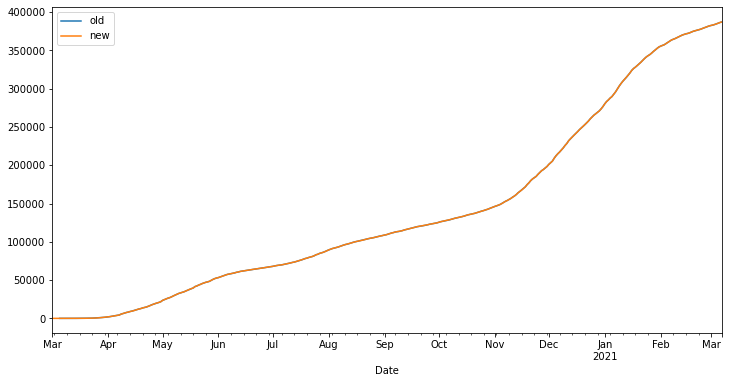

In [17]:
## Matched positive -> Cases
ax = old_md['positive'].plot(label='old')
new_md['Cases'].plot(label='new', ax=ax)
ax.legend()

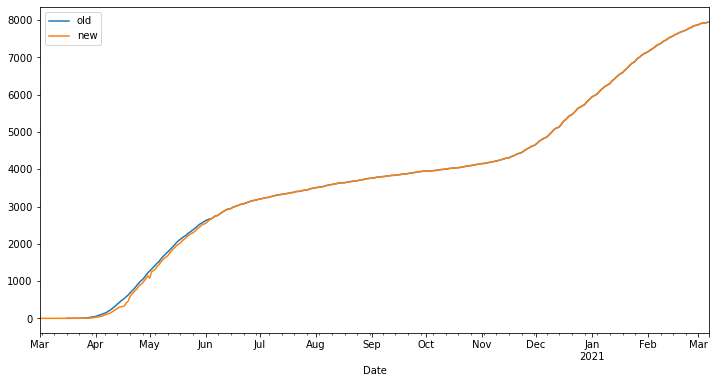

In [18]:
## Matched death -> Deaths
ax = old_md['death'].plot(label='old')
new_md['Deaths'].plot(label='new', ax=ax)
ax.legend()

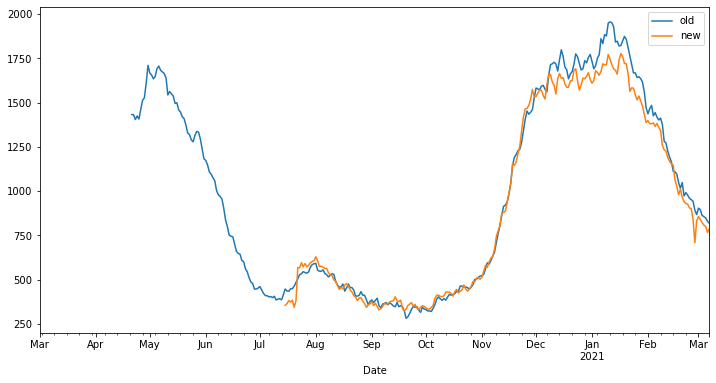

In [19]:
## Matched hospitalizedCurrenlty
ax = old_md['hospitalizedCurrently'].plot(label='old')
new_md['total_adult_patients_hospitalized_confirmed_covid'].plot(label='new',
                                                                ax=ax)
ax.legend()

In [20]:
res.sort_values('RMSE').head()

,Old Col,New Col,RMSE
1,death,Deaths,419.720769
20,death,inpatient_beds_used_covid,3237.299521
11,death,percent_of_inpatients_with_covid_numerator,3250.602314
4,death,inpatient_bed_covid_utilization_numerator,3250.885864
38,death,total_adult_patients_hospitalized_confirmed_an...,3390.231567


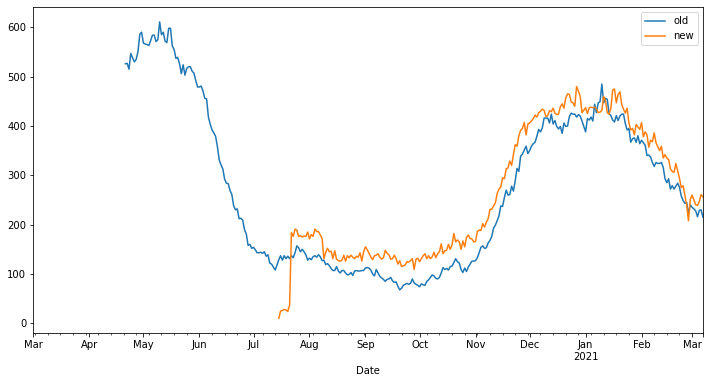

In [21]:
## Matched inIcuCurrently
ax = old_md['inIcuCurrently'].plot(label='old')
new_md['adult_icu_bed_covid_utilization_numerator'].plot(label='new',
                                                                ax=ax)
ax.legend()

In [22]:
# compare_old_vs_new_cols(old_md,new_md,old_col='inIcuCurrently')

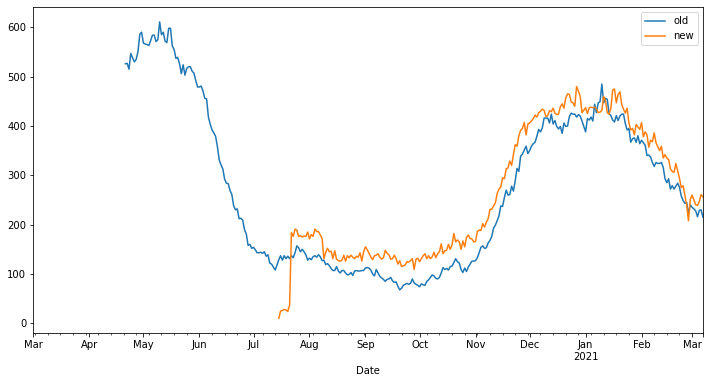

In [23]:
ax = old_md['inIcuCurrently'].plot(label='old')
new_md['adult_icu_bed_covid_utilization_numerator'].plot(ax=ax,label='new')
ax.legend()

### MATCHING COLUMN MAPPER
- old "`death`"== new "`Deaths`
- old "`positive`"== new "`Cases`
- old "`hospitalizedCurrently`" ==`adult_icu_bed_covid_utilization_numerator`
    
- old "`inIcuCurrently`" == `adult_icu_bed_covid_utilization_numerator`
       

In [24]:
## making mapper dict to rename new columns
new_to_match_old_map = {
    'Deaths':'death',
    'Cases':'positive',
    'total_adult_patients_hospitalized_confirmed_covid':'hospitalizedCurrently',
'adult_icu_bed_covid_utilization_numerator':'inIcuCurrently'}

In [25]:
new_md[list(new_to_match_old_map.keys())]

,Deaths,Cases,total_adult_patients_hospitalized_confirmed_covid,adult_icu_bed_covid_utilization_numerator
Date,,,,
2020-03-01,0,0,NaN,NaN
2020-03-03,0,0,NaN,NaN
2020-03-04,0,0,NaN,NaN
2020-03-05,0,0,NaN,NaN
2020-03-06,0,3,NaN,NaN
...,...,...,...,...
2021-03-04,7922,384765,808.0,239.0
2021-03-05,7930,385678,801.0,247.0
2021-03-06,7941,386610,767.0,261.0


In [26]:
old_md[list(new_to_match_old_map.values())]

,death,positive,hospitalizedCurrently,inIcuCurrently
Date,,,,
2021-03-07,7955.0,387319.0,818.0,215.0
2021-03-06,7941.0,386610.0,830.0,230.0
2021-03-05,7930.0,385678.0,849.0,229.0
2021-03-04,7922.0,384765.0,856.0,216.0
2021-03-03,7919.0,383956.0,863.0,228.0
...,...,...,...,...
2020-03-09,NaN,5.0,NaN,NaN
2020-03-08,NaN,3.0,NaN,NaN
2020-03-07,NaN,3.0,NaN,NaN


## Processing All `STATES` hospital data

In [27]:
## making mapper dict to rename new columns
new_to_final_names = {
    'Deaths':'Deaths',
    'Cases':'Cases',
    'total_adult_patients_hospitalized_confirmed_covid':'Hospitalized Currently',
'adult_icu_bed_covid_utilization_numerator':'ICU-Covid Currently'}
list(new_to_final_names.keys())

['Deaths',
 'Cases',
 'total_adult_patients_hospitalized_confirmed_covid',
 'adult_icu_bed_covid_utilization_numerator']

In [28]:
import datetime as dt
today = dt.date.today()
today

datetime.date(2021, 8, 18)

In [29]:
# len(np.unique(list(STATES.keys())))
# toda
date_index = pd.date_range(pd.Timestamp('2020-01-22 00:00:00'),today)
date_index.name="Date"
date_index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-08-14', '2021-08-15', '2021-08-16',
               '2021-08-17', '2021-08-18'],
              dtype='datetime64[ns]', name='Date', length=575, freq='D')

In [51]:
# df_time = pd.DataFrame(index=date_index)
# df_time

In [31]:
# final_states.join(md)
# final_states

In [32]:
STATES['NY']

,Cases,Deaths,inpatient_bed_covid_utilization_coverage,staffed_adult_icu_bed_occupancy_coverage,inpatient_bed_covid_utilization_numerator,percent_of_inpatients_with_covid,percent_of_inpatients_with_covid_coverage,deaths_covid_coverage,inpatient_beds,adult_icu_bed_utilization,deaths_covid,percent_of_inpatients_with_covid_numerator,total_adult_patients_hospitalized_confirmed_covid_coverage,inpatient_bed_covid_utilization,inpatient_beds_utilization,adult_icu_bed_utilization_coverage,total_pediatric_patients_hospitalized_confirmed_covid_coverage,adult_icu_bed_covid_utilization_denominator,total_staffed_adult_icu_beds,total_pediatric_patients_hospitalized_confirmed_covid,inpatient_beds_used_covid,inpatient_bed_covid_utilization_denominator,total_staffed_adult_icu_beds_coverage,inpatient_beds_utilization_coverage,adult_icu_bed_covid_utilization_coverage,staffed_adult_icu_bed_occupancy,total_adult_patients_hospitalized_confirmed_and_suspected_covid_coverage,percent_of_inpatients_with_covid_denominator,adult_icu_bed_utilization_denominator,inpatient_beds_used,inpatient_beds_used_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,inpatient_beds_coverage,total_adult_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization_numerator,inpatient_beds_used_covid_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid,adult_icu_bed_covid_utilization,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_coverage,adult_icu_bed_utilization_numerator
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-14,557,5,2.0,0,6.0,0.000000,1.0,1,2145.0,NaN,0.0,0.0,0,0.002797,0.906667,NaN,0,NaN,NaN,NaN,6.0,2145.0,0,1.0,NaN,NaN,0,68.0,NaN,68.0,1,68.0,75.0,2,NaN,NaN,NaN,2,NaN,NaN,0,NaN
2020-03-14,557,5,2.0,0,6.0,0.000000,1.0,1,2145.0,NaN,0.0,0.0,0,0.002797,0.906667,NaN,0,NaN,NaN,NaN,6.0,2145.0,0,1.0,NaN,NaN,0,68.0,NaN,68.0,1,68.0,75.0,2,NaN,NaN,NaN,2,NaN,NaN,0,NaN
2020-03-15,633,10,3.0,0,88.0,0.055034,3.0,3,1960.0,NaN,0.0,88.0,0,0.044898,0.815816,NaN,0,NaN,NaN,NaN,88.0,1960.0,0,3.0,NaN,NaN,0,1599.0,NaN,1599.0,3,1599.0,1960.0,3,NaN,NaN,NaN,3,NaN,NaN,0,NaN
2020-03-16,961,21,4.0,0,97.0,0.057876,4.0,4,2161.0,NaN,2.0,97.0,0,0.044887,0.775567,NaN,0,NaN,NaN,NaN,97.0,2161.0,0,4.0,NaN,NaN,0,1676.0,NaN,1676.0,4,1676.0,2161.0,4,NaN,NaN,NaN,4,NaN,NaN,0,NaN
2020-03-17,1407,35,4.0,0,128.0,0.076100,4.0,4,2161.0,NaN,1.0,128.0,0,0.059232,0.778343,NaN,0,NaN,NaN,NaN,128.0,2161.0,0,4.0,NaN,NaN,0,1682.0,NaN,1682.0,4,1682.0,2161.0,4,NaN,NaN,NaN,4,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-13,2196866,53840,200.0,209,2176.0,0.054966,200.0,200,50855.0,0.661907,13.0,2176.0,209,0.043284,0.784013,209.0,200,5078.0,5182.0,32.0,2176.0,50273.0,209,209.0,200.0,3430.0,200,39588.0,5182.0,39871.0,209,39871.0,50855.0,209,1662.0,66.0,398.0,200,2110.0,0.078377,200,3430.0
2021-08-14,2201468,53855,200.0,209,2121.0,0.055497,200.0,200,50849.0,0.653207,16.0,2121.0,209,0.042195,0.757399,209.0,200,5072.0,5176.0,34.0,2121.0,50267.0,209,209.0,200.0,3381.0,200,38218.0,5176.0,38513.0,209,38513.0,50849.0,209,1677.0,69.0,384.0,200,2052.0,0.075710,200,3381.0
2021-08-15,2205869,54090,200.0,209,2211.0,0.058399,200.0,200,50833.0,0.638771,15.0,2211.0,209,0.043999,0.750418,209.0,200,5070.0,5174.0,35.0,2211.0,50251.0,209,209.0,200.0,3305.0,200,37860.0,5174.0,38146.0,209,38146.0,50833.0,209,1724.0,73.0,418.0,200,2138.0,0.082446,200,3305.0


In [33]:
new_to_final_names

{'Deaths': 'Deaths',
 'Cases': 'Cases',
 'total_adult_patients_hospitalized_confirmed_covid': 'Hospitalized Currently',
 'adult_icu_bed_covid_utilization_numerator': 'ICU-Covid Currently'}

In [34]:
## saving final version of dataset
FINAL_STATES = {} #pd.DataFrame(index=date_index)

for state, state_df in STATES.items():
    
    state_df = state_df[list(new_to_final_names.keys())].copy().sort_index()
    state_df = state_df.rename(new_to_final_names,axis=1)

#     state_df.columns = [f"{state}: {c}" for c in state_df.columns]
    FINAL_STATES[state]= state_df.copy()

FINAL_STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [35]:
FINAL_STATES['MD']

,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently
Date,,,,
2020-03-01,0,0,NaN,NaN
2020-03-03,0,0,NaN,NaN
2020-03-04,0,0,NaN,NaN
2020-03-05,0,0,NaN,NaN
2020-03-06,0,3,NaN,NaN
...,...,...,...,...
2021-08-14,9887,479083,548.0,151.0
2021-08-15,9891,479952,570.0,155.0
2021-08-15,9891,479952,570.0,155.0


# Time Series Modeling

In [36]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa
from pmdarima import auto_arima

## MD

In [58]:
state = "MD"
df_state = FINAL_STATES[state].loc['08-2020':].copy()
# df_state = df_state.interpolate('time')
df_state['Deaths-New'] = df_state['Deaths'].diff()
df_state['Cases-New'] = df_state['Cases'].diff()
df_state = df_state.resample('D').sum()

print(df_state.isna().sum())
df_state

Deaths                    0
Cases                     0
Hospitalized Currently    0
ICU-Covid Currently       0
Deaths-New                0
Cases-New                 0
dtype: int64


,Deaths,Cases,Hospitalized Currently,ICU-Covid Currently,Deaths-New,Cases-New
Date,,,,,,
2020-08-01,3506,89365,629.0,171.0,0.0,0.0
2020-08-02,3515,90274,606.0,180.0,9.0,909.0
2020-08-03,3523,91144,574.0,176.0,8.0,870.0
2020-08-04,3530,91854,576.0,191.0,7.0,710.0
2020-08-05,3536,92426,571.0,186.0,6.0,572.0
...,...,...,...,...,...,...
2021-08-13,9878,478067,514.0,156.0,5.0,950.0
2021-08-14,9887,479083,548.0,151.0,9.0,1016.0
2021-08-15,19782,959904,1140.0,310.0,4.0,869.0


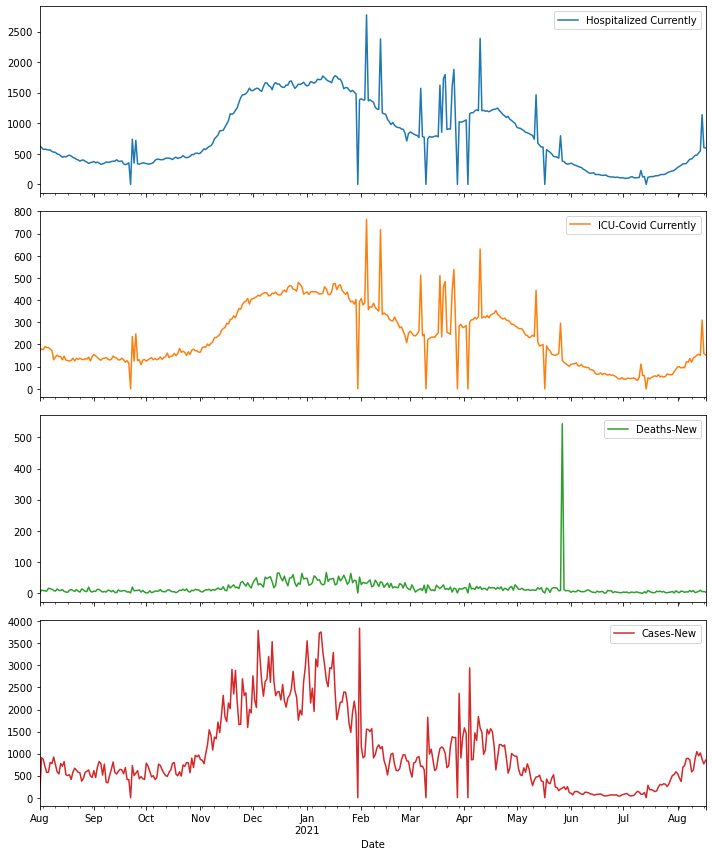

In [59]:
model_cols = ['Hospitalized Currently','ICU-Covid Currently',
              'Deaths-New','Cases-New'
             ]

## visualize
ax = df_state[model_cols].plot(subplots=True, figsize=(10,12))
plt.tight_layout();

#### Data Quality Issues
- There are strong spikes +/- that are not likely to be real values.

### MD - Cases-New

Text(0, 0.5, 'Cases-New')

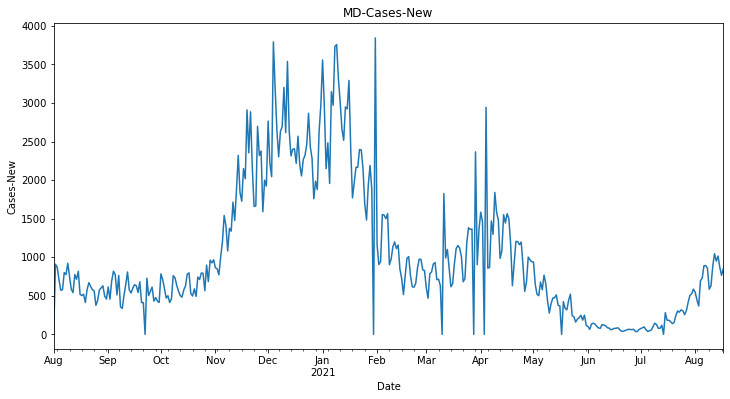

In [60]:
col = 'Cases-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 07-19-2021


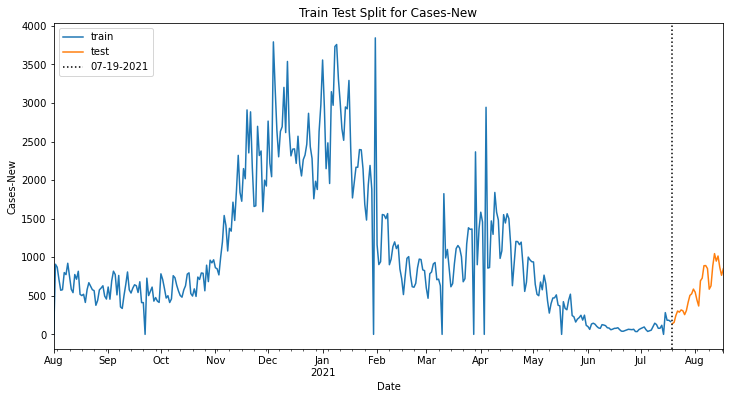

In [61]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

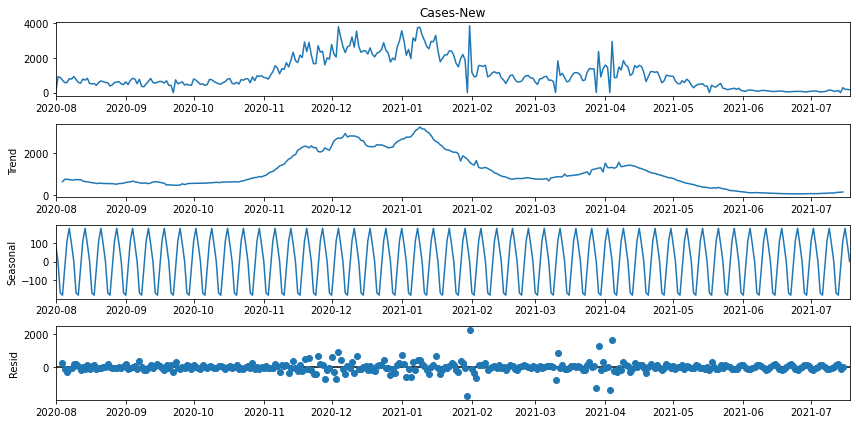

In [62]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

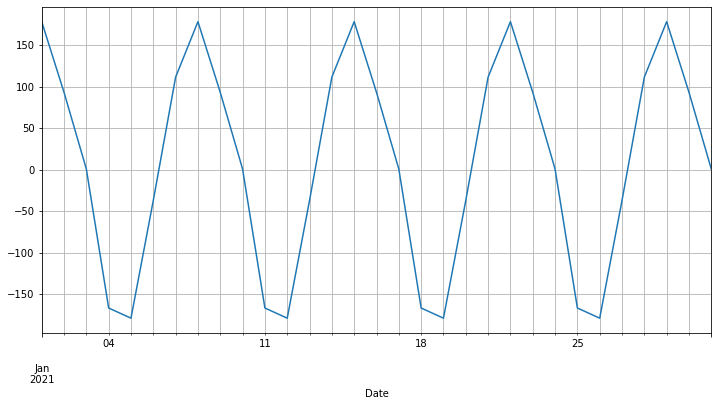

In [63]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.734346,17,327,0.068281,False,False


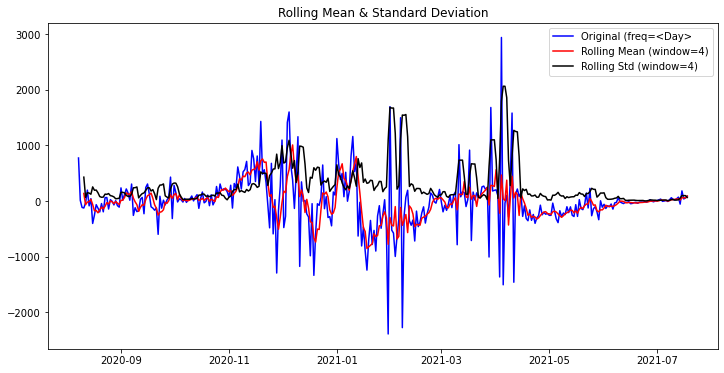

In [64]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

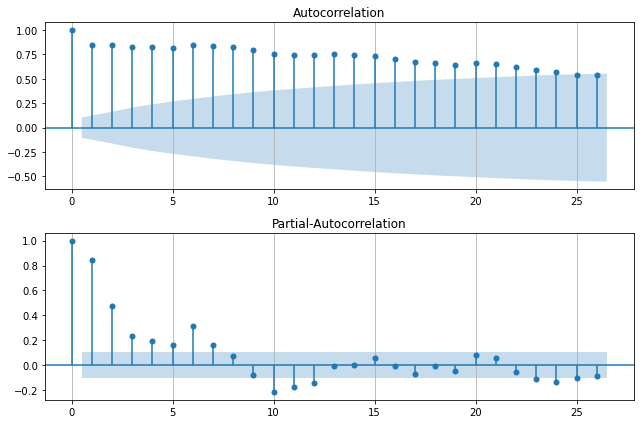

In [65]:
fn.modeling.plot_acf_pacf(train,);

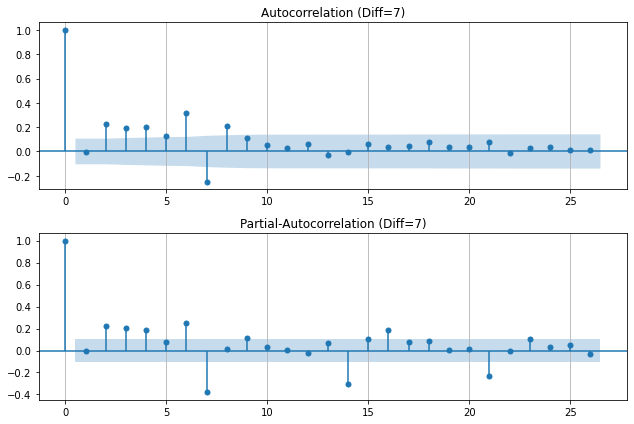

In [66]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [67]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=5271.019, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=5244.679, Time=0.35 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5246.111, Time=0.31 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=5269.156, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=5273.022, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=5236.558, Time=0.79 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=5238.457, Time=1.11 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=5238.267, Time=0.55 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=5251.463, Time=0.79 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=5174.762, Time=1.04 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=5205.293, Time=0.38 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=3.07 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=5141.072, Time=1.19 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=5139.052, Time=0.99 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  352
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -2531.478
Date:                             Wed, 18 Aug 2021   AIC                           5074.956
Time:                                     19:10:52   BIC                           5098.017
Sample:                                          0   HQIC                          5084.140
                                             - 352                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2233      0.909     -0.246      0.806      -2.006       1.559
ar.L1          0.9870      0.011     87.448      0.000       0.965       1.009
ma.L1         -0.9242      0.034    -27.405      0.000      -0.990      -0.858
ma.L2          0.2187      0.044      5.025      0.000       0.133       0.304
ma.S.L7       -0.8815      0.035    -24.966      0.000      -0.951      -0.812
sigma2       1.35e+05   5658.178     23.865      0.000    1.24e+05    1.46e+05
===================================================================================
Ljung-Box (Q):                       35.36   Jarque-Bera (JB):              1692.87
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Cases-New   No. Observations:                  352
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -2458.201
Date:                             Wed, 18 Aug 2021   AIC                           4926.402
Time:                                     19:10:53   BIC                           4945.472
Sample:                                 08-01-2020   HQIC                          4934.005
                                      - 07-18-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9897      0.009    105.516      0.000       0.971       1.008
ma.L1         -0.9198      0.026    -35.326      0.000      -0.971      -0.869
ma.L2          0.2151      0.041      5.286      0.000       0.135       0.295
ma.S.L7       -0.9053      0.036    -25.466      0.000      -0.975      -0.836
sigma2      1.353e+05   5567.092     24.295      0.000    1.24e+05    1.46e+05
===================================================================================
Ljung-Box (Q):                       37.90   Jarque-Bera (JB):              1681.60
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.46
Prob(H) (two-sided):                  0.46   Kurtosis:                        13.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

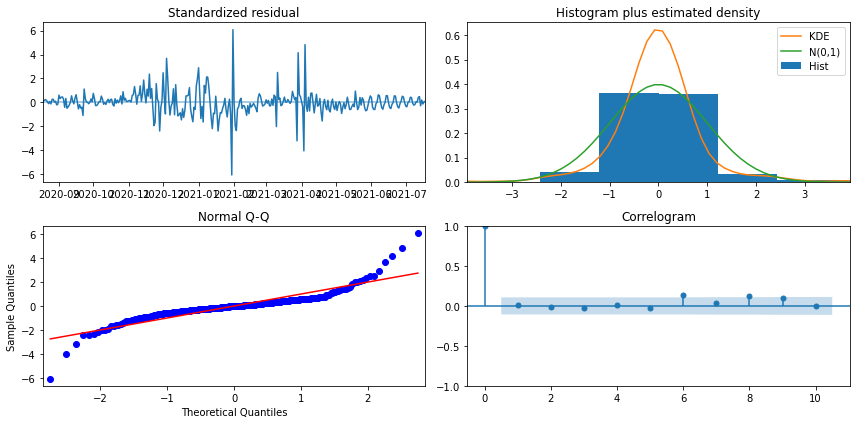

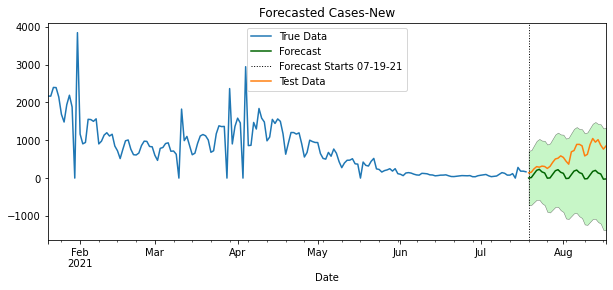

In [68]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Cases-New   No. Observations:                  382
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -2664.063
Date:                             Wed, 18 Aug 2021   AIC                           5338.126
Time:                                     19:10:54   BIC                           5357.625
Sample:                                 08-01-2020   HQIC                          5345.875
                                      - 08-17-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9894      0.009    113.984      0.000       0.972       1.006
ma.L1         -0.9110      0.024    -37.739      0.000      -0.958      -0.864
ma.L2          0.2127      0.039      5.510      0.000       0.137       0.288
ma.S.L7       -0.9120      0.033    -27.948      0.000      -0.976      -0.848
sigma2      1.252e+05   4783.223     26.164      0.000    1.16e+05    1.35e+05
===================================================================================
Ljung-Box (Q):                       43.09   Jarque-Bera (JB):              2201.90
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Cases-New'}, xlabel='Date'>)

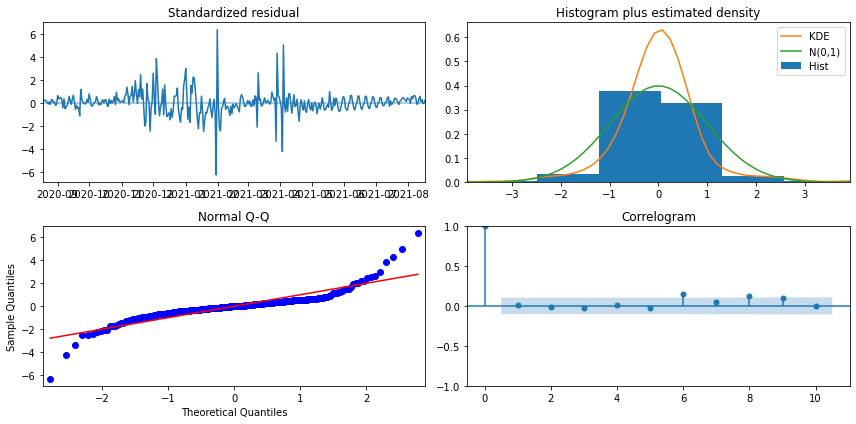

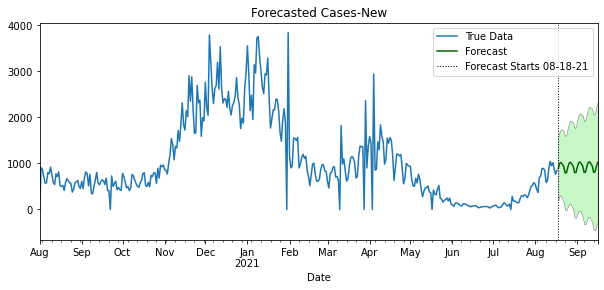

In [69]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

### MD - Deaths-New

Text(0, 0.5, 'Deaths-New')

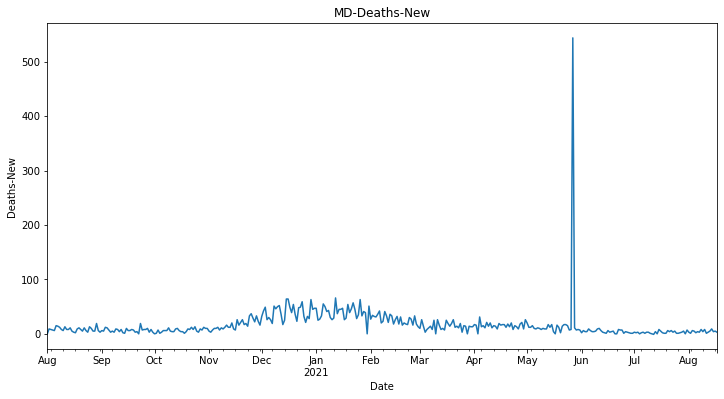

In [84]:
col = 'Deaths-New'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 07-19-2021


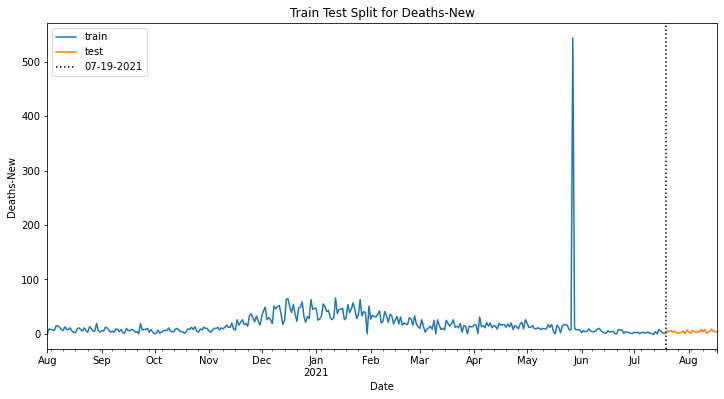

In [85]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

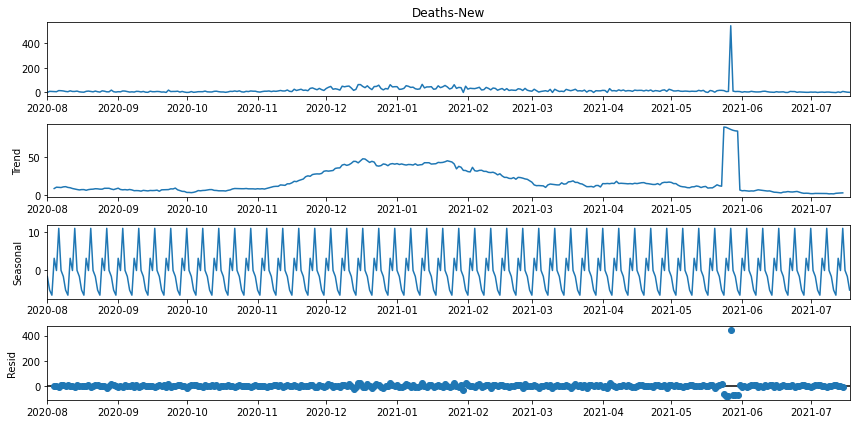

In [86]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

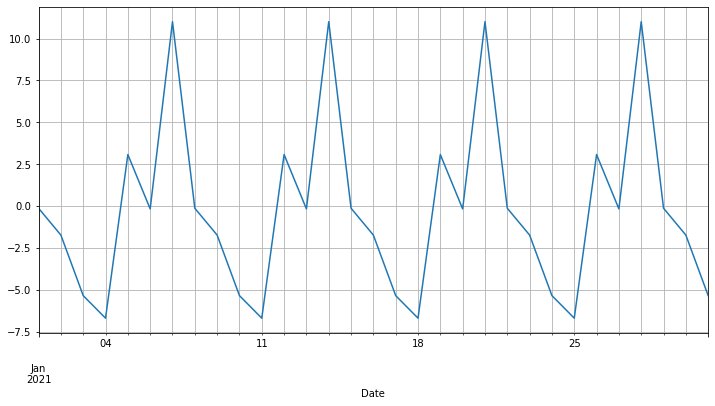

In [87]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-7.649403,13,331,1.806082e-11,True,True


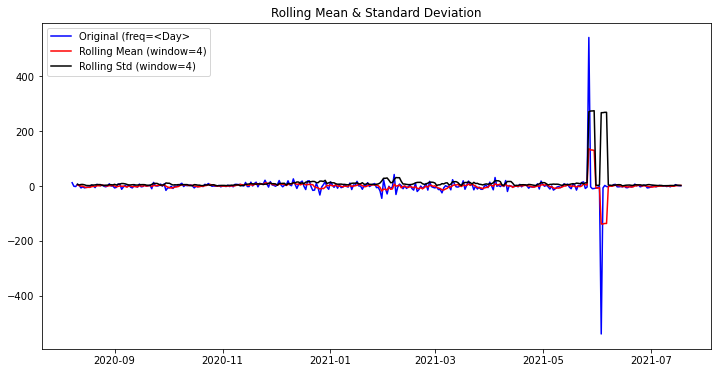

In [88]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

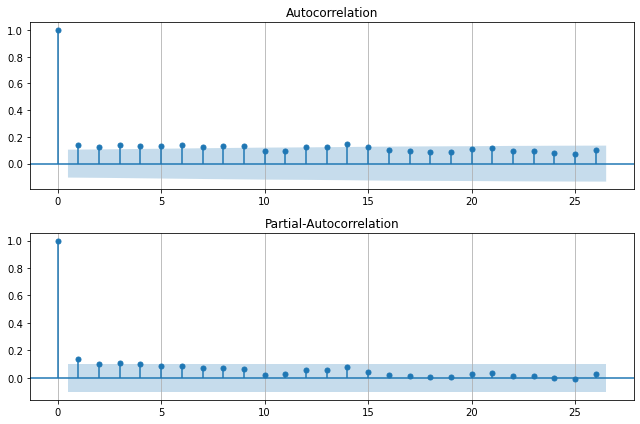

In [89]:
fn.modeling.plot_acf_pacf(train,);

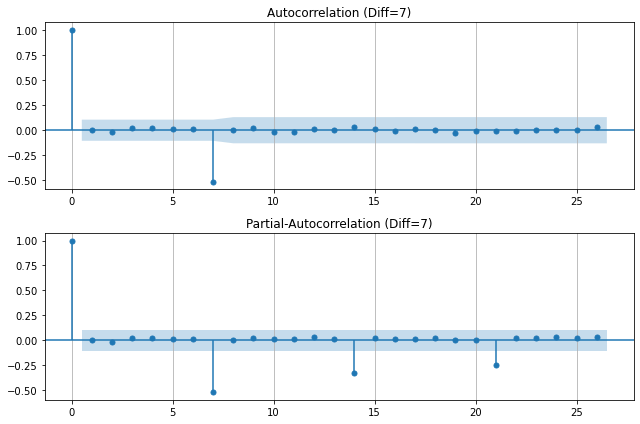

In [90]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [91]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3564.798, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3465.549, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3383.327, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3562.800, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=3566.798, Time=0.08 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=3385.274, Time=1.50 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=3465.549, Time=0.22 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=3387.327, Time=1.74 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=3383.891, Time=0.19 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=3382.933, Time=0.60 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=3566.798, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  352
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1687.477
Date:                             Wed, 18 Aug 2021   AIC                           3380.953
Time:                                     19:15:48   BIC                           3392.484
Sample:                                          0   HQIC                          3385.545
                                             - 352                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0979      0.032      3.039      0.002       0.035       0.161
ma.S.L7       -0.8792      0.021    -40.975      0.000      -0.921      -0.837
sigma2      1006.7794      8.547    117.790      0.000     990.027    1023.532
===================================================================================
Ljung-Box (Q):                       46.61   Jarque-Bera (JB):            700804.48
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):              66.93   Skew:                            13.25
Prob(H) (two-sided):                  0.00   Kurtosis:                       222.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Deaths-New   No. Observations:                  352
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1650.290
Date:                             Wed, 18 Aug 2021   AIC                           3306.581
Time:                                     19:15:49   BIC                           3318.041
Sample:                                 08-01-2020   HQIC                          3311.149
                                      - 07-18-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1009      0.032      3.156      0.002       0.038       0.164
ma.S.L7       -0.8851      0.022    -39.466      0.000      -0.929      -0.841
sigma2      1029.0291      9.015    114.141      0.000    1011.359    1046.699
===================================================================================
Ljung-Box (Q):                       47.55   Jarque-Bera (JB):            654213.46
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              44.57   Skew:                            13.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       217.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

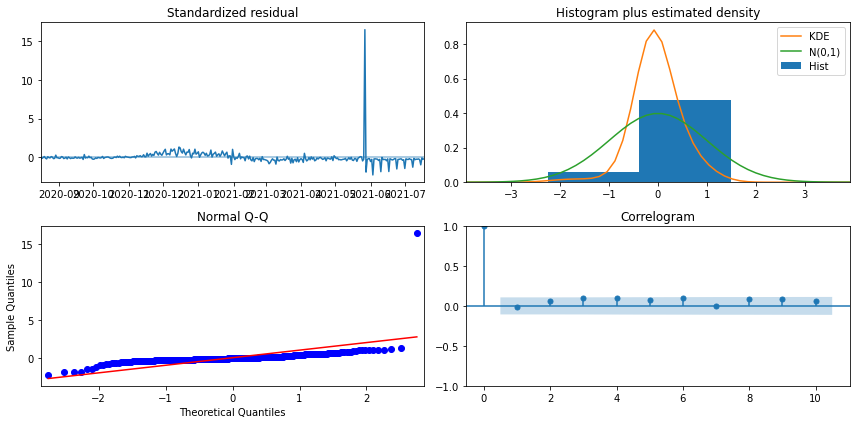

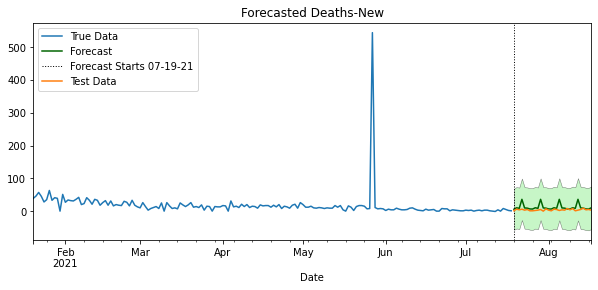

In [92]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          Deaths-New   No. Observations:                  382
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1782.887
Date:                             Wed, 18 Aug 2021   AIC                           3571.775
Time:                                     19:15:50   BIC                           3583.491
Sample:                                 08-01-2020   HQIC                          3576.430
                                      - 08-17-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0958      0.031      3.063      0.002       0.034       0.157
ma.S.L7       -0.8697      0.020    -44.419      0.000      -0.908      -0.831
sigma2       955.2127      7.550    126.513      0.000     940.414     970.011
===================================================================================
Ljung-Box (Q):                       50.56   Jarque-Bera (JB):            825903.55
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):              23.49   Skew:                            13.54
Prob(H) (two-sided):                  0.00   Kurtosis:                       233.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Deaths-New'}, xlabel='Date'>)

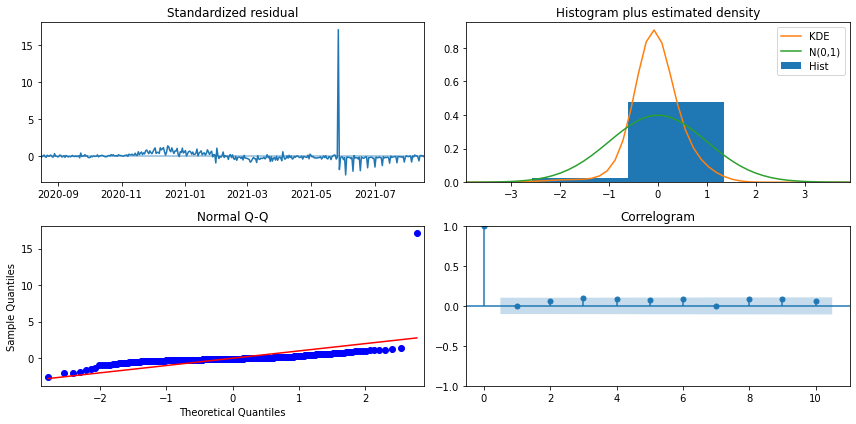

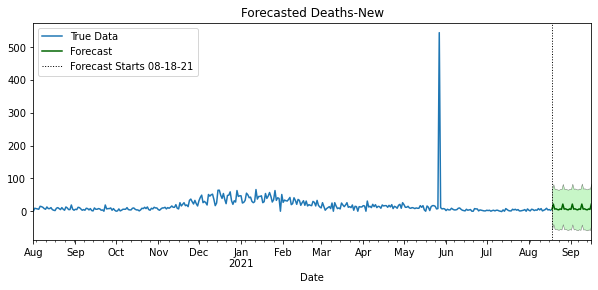

In [93]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

### MD - Hospitalized Currently

In [94]:
# df_state['Hospitalized Currently']

Text(0, 0.5, 'Hospitalized Currently')

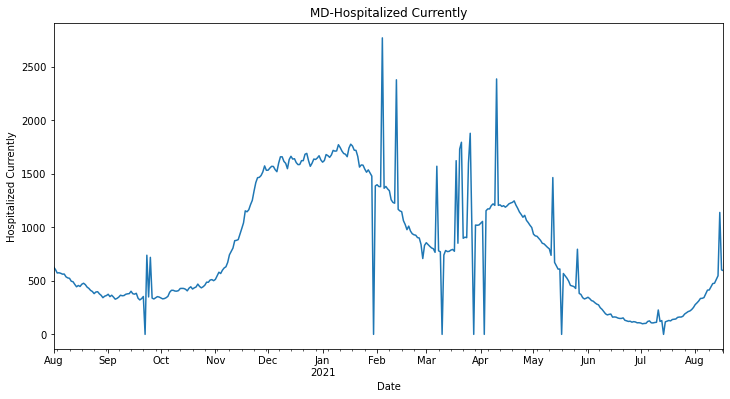

In [95]:
col = 'Hospitalized Currently'
ts = df_state[col].copy()
ax = ts.plot(title=f"{state}-{col}");
ax.set_ylabel(col)

#### Train Test Split

Using a cutoff index of -30, which = 07-19-2021


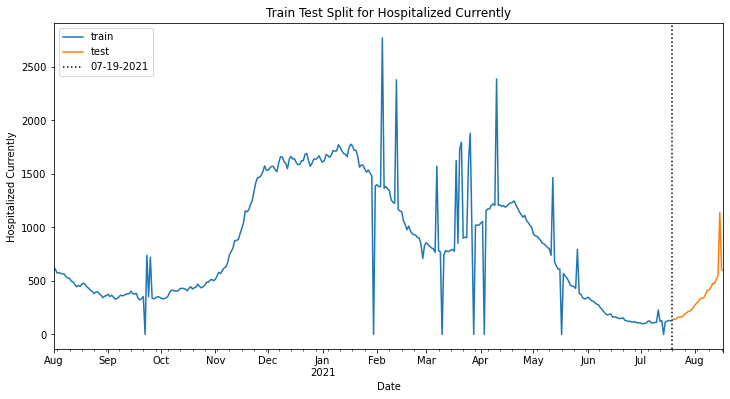

In [96]:
train,test = fn.modeling.train_test_split_ts(ts,split_index=-30)

#### Checking Seasonal Decompose for Seasonality to Use

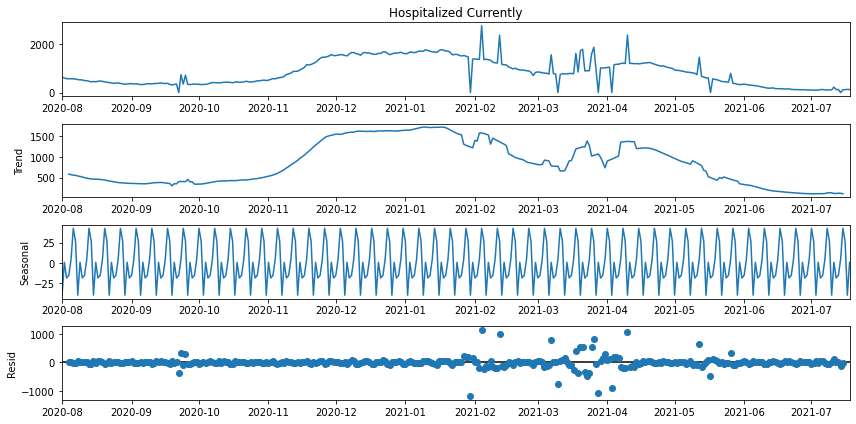

In [97]:
## Get Decomposed time sereis
decomp = tsa.seasonal_decompose(train)
decomp.plot();

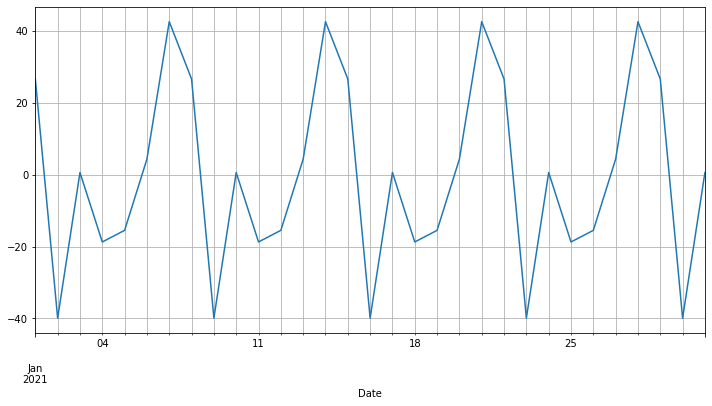

In [98]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-2.798795,17,327,0.058446,False,False


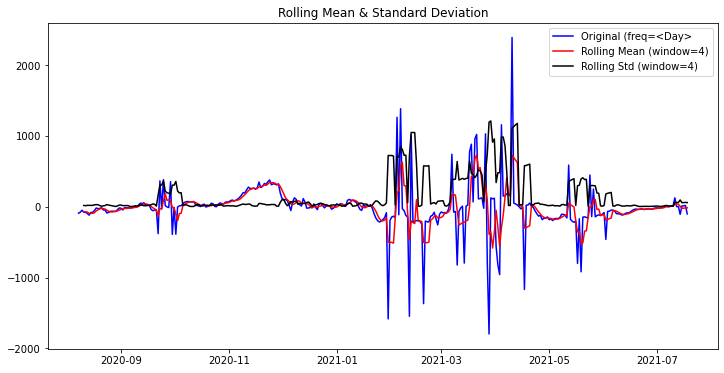

In [99]:
fn.modeling.stationarity_check(train.diff(7).dropna(),window=4);

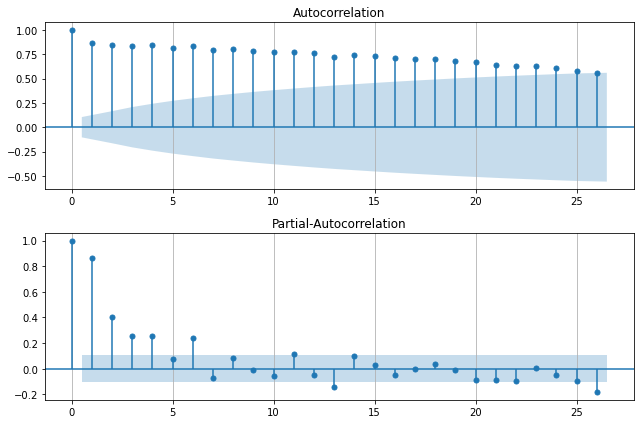

In [100]:
fn.modeling.plot_acf_pacf(train,);

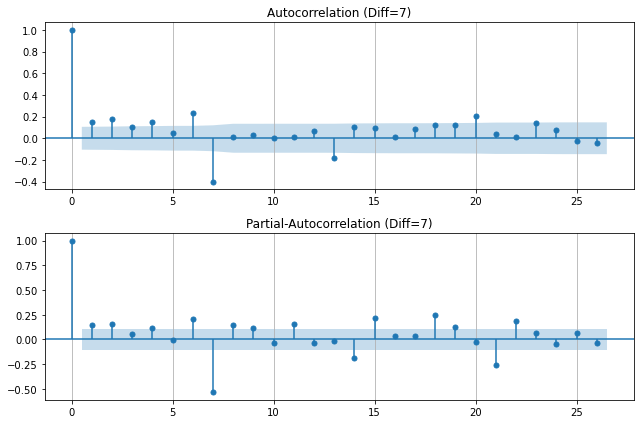

In [101]:
fn.modeling.plot_acf_pacf(train,diff=7);

> Add notes about COVID insights from acf/pacf

#### GridSearch SARIMA Orders

In [102]:
from pmdarima import auto_arima

auto_model = auto_arima(train,m=7,trace=True,D=1,
                        start_p=0, start_q=0,
                        start_P=0, start_Q=0)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=4999.702, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=4898.909, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=4919.151, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=4997.985, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=4993.910, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=4884.824, Time=0.74 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=4878.918, Time=2.19 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=4876.881, Time=0.95 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=4886.451, Time=0.62 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=4878.839, Time=1.70 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=4877.590, Time=1.62 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=4942.987, Time=0.42 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=4832.567, Time=1.28 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  352
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -2410.284
Date:                             Wed, 18 Aug 2021   AIC                           4832.567
Time:                                     19:16:30   BIC                           4855.629
Sample:                                          0   HQIC                          4841.751
                                             - 352                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.3482      1.346     -0.259      0.796      -2.986       2.289
ar.L1          0.5364      0.029     18.787      0.000       0.480       0.592
ar.L2          0.3941      0.031     12.866      0.000       0.334       0.454
ar.S.L7       -0.0948      0.042     -2.231      0.026      -0.178      -0.012
ma.S.L7       -0.9238      0.028    -33.348      0.000      -0.978      -0.869
sigma2      6.606e+04   2272.745     29.068      0.000    6.16e+04    7.05e+04
===================================================================================
Ljung-Box (Q):                       97.90   Jarque-Bera (JB):              2088.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.28   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Use Best Params for new SARIMAX

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              Hospitalized Currently   No. Observations:                  352
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -2348.331
Date:                             Wed, 18 Aug 2021   AIC                           4706.661
Time:                                     19:16:30   BIC                           4725.747
Sample:                                 08-01-2020   HQIC                          4714.269
                                      - 07-18-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5341      0.026     20.317      0.000       0.483       0.586
ar.L2          0.4016      0.027     14.704      0.000       0.348       0.455
ar.S.L7       -0.0828      0.030     -2.740      0.006      -0.142      -0.024
ma.S.L7       -1.0000      0.033    -30.322      0.000      -1.065      -0.935
sigma2      6.441e+04   5.12e-07   1.26e+11      0.000    6.44e+04    6.44e+04
===================================================================================
Ljung-Box (Q):                       95.34   Jarque-Bera (JB):              1819.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.46   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.14e+25. Standard errors may be unstable.
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

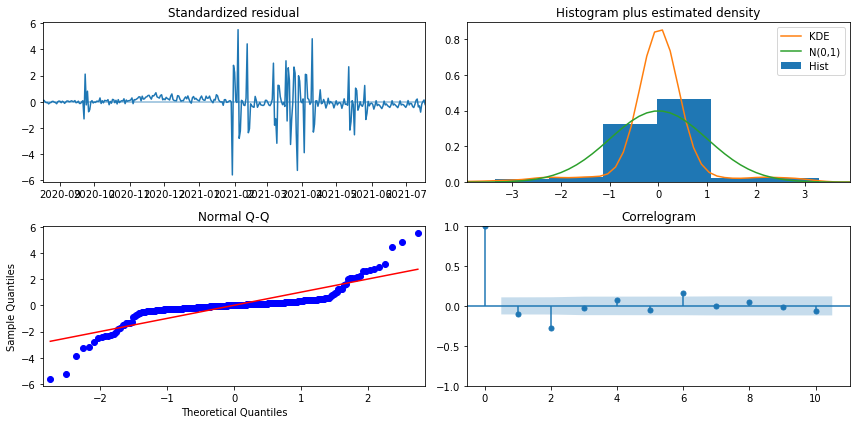

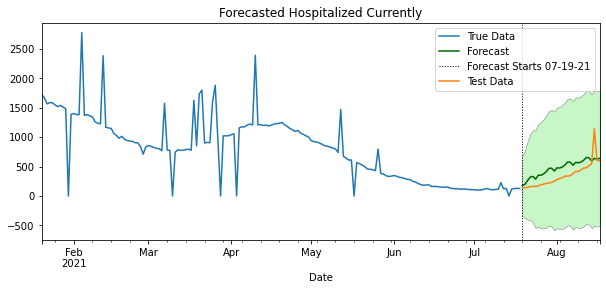

In [103]:
model = tsa.SARIMAX(train, order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()

fn.modeling.evaluate_model(model,train,test,last_n_lags=180)

#### Next: if happy with forecast, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              Hospitalized Currently   No. Observations:                  382
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -2545.908
Date:                             Wed, 18 Aug 2021   AIC                           5101.816
Time:                                     19:16:32   BIC                           5121.329
Sample:                                 08-01-2020   HQIC                          5109.570
                                      - 08-17-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5352      0.025     21.744      0.000       0.487       0.583
ar.L2          0.4011      0.026     15.664      0.000       0.351       0.451
ar.S.L7       -0.0806      0.028     -2.843      0.004      -0.136      -0.025
ma.S.L7       -1.0000      0.031    -32.385      0.000      -1.061      -0.939
sigma2      6.053e+04    5.1e-07   1.19e+11      0.000    6.05e+04    6.05e+04
===================================================================================
Ljung-Box (Q):                      100.96   Jarque-Bera (JB):              2222.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+25. Standard errors may be unstable.
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted Hospitalized Currently'}, xlabel='Date'>)

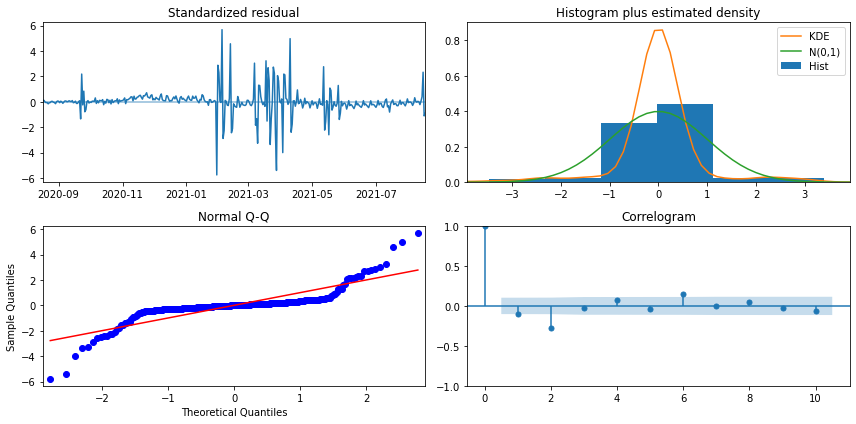

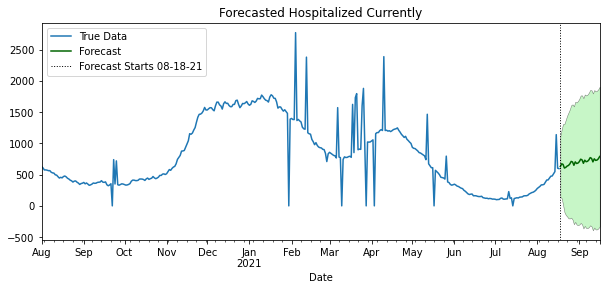

In [104]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                    seasonal_order =auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False, 
                    freq='D').fit()
fn.modeling.diagnose_model(model)
fn.modeling.plot_forecast(model, ts)

# APPENDIX

### `def` modeling functions

In [105]:
# def train_test_split_ts(ts,test_size=0.9,split_index=None):
#     """Uses test size by default, split_index overrides it"""
#     if split_index is not None:
#         tts_cutoff = split_index
#     else:
#         tts_cutoff = round(ts.shape[0]*0.9)
#     fmt = "%m-%d-%Y"
#     cutoff_time = ts.index[tts_cutoff]
#     print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
#       ## Use the tts cutoff to do Train test split and plot
#     train = ts.iloc[:tts_cutoff]
#     test = ts.iloc[tts_cutoff:]

#     ## Plot
#     ax = train.plot(label='train')
#     test.plot(label='test')
#     ax.legend()
#     ax.set(ylabel=ts.name)
#     ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
#     ax.legend()
#     ax.set_title(f"Train Test Split for {ts.name}")
#     return train, test


In [106]:
# ## funtionize diagnosing
# def diagnose_model(model): #keep
#     """Takes a fit statsmodels model and displays the .summary 
#     and plots the built-in plot.diagnostics()"""
#     display(model.summary())
#     model.plot_diagnostics()
#     plt.tight_layout()
    
    
# def get_forecast(model,steps=14): #keep
#     forecast = model.get_forecast(steps=steps)
#     forecast_df = forecast.conf_int()
#     forecast_df['Forecast'] = forecast.predicted_mean
#     forecast_df.columns = ['Lower CI','Upper CI','Forecast']
#     return forecast_df


# def plot_forecast(forecast_df,ts,orig_label='True Data',
#                   forecast_label='Forecast',
#                   forecast_steps=30,
#                   last_n_lags=None,figsize=(10,4)):
#     """Takes a forecast_df from get_df_from_pred and optionally 
#     the training/original time series.
    
#     Plots the original ts, the predicted mean and the 
#     confidence invtervals (using fill between)"""
#     if not isinstance(forecast_df,pd.DataFrame):
#         forecast_df = get_forecast(forecast_df,steps=forecast_steps)
        
#     fig,ax = plt.subplots(figsize=figsize)

#     if last_n_lags is None:
#         last_n_lags = len(ts)
        
#     ts.iloc[-last_n_lags:].plot(label='True Data')

    
#     forecast_df['Forecast'].plot(ax=ax,color='darkgreen',label=forecast_label)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['Lower CI'], 
#                     forecast_df['Upper CI'],
#                     color='lightgreen',alpha=0.5,lw=0.5,edgecolor='k')
#     ax.set(title=f'Forecasted {ts.name}')
#     sep = forecast_df.index[0]
#     ax.axvline(sep,label=f"Forecast Starts {sep.strftime('%m-%d-%y')}",lw=1,ls=':',c='k')
#     ax.legend()

#     return fig,ax

    
# def evaluate_model(model,train,test,steps=None,last_n_lags=None):
#     diagnose_model(model)
    
#     if steps is None:
#         steps=len(test)
        
#     forecast_df = get_forecast(model,steps=len(test))
#     fig, ax = plot_forecast(forecast_df,train,last_n_lags=last_n_lags)
    
#     test.plot(ax=ax,label='Test Data')
#     ax.legend()
#     return fig,ax
           
 
